In [1]:
import pandas as pd
import numpy as np
import pathlib as pl
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import ks_2samp
from tqdm.notebook import tqdm

In [3]:
import sys
sys.path.append("../../FinalCode/")
import download.download_gex as dwnl
import utils.plotting as plting

In [4]:
colors = sns.color_palette("muted")
palette = {"Healthy": colors[0], "NAC": colors[1], "Adenoma": colors[7], "SSL": colors[4], "Cancer": colors[5],}

In [5]:
fig_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/ArticleFigures/unit")

# Load mapping

In [6]:
mapping_roadmap = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/FinalData/NIH_Epigenomics_Roadmap/EPIC_to_state_mapping.csv",index_col=0)

In [7]:
union_cpgs = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP/union_cpgs.csv",index_col=0).values.ravel()

In [8]:
epic_manifest = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/illumina_manifests/GPL21145_MethylationEPIC_15073387_v-1-0.csv.gz",skiprows=7,index_col=0)

/var/folders/y0/0jmz5bl96kb57fmb09fl6fdw0000gn/T/ipykernel_21300/2459526395.py:1: DtypeWarning: Columns (0,2,4,5,6,7,8,9,11,13,14,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,34,36,38,39,40,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  epic_manifest = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/illumina_manifests/GPL21145_MethylationEPIC_15073387_v-1-0.csv.gz",skiprows=7,index_col=0)


In [9]:
epic_manifest = epic_manifest.loc[union_cpgs]
epic_manifest = pd.concat([epic_manifest,mapping_roadmap],axis=1,join="inner")

red_manifest = epic_manifest[['CHR', 'MAPINFO',
       'UCSC_RefGene_Name', 
       'UCSC_RefGene_Group', 'UCSC_CpG_Islands_Name',
       'Relation_to_UCSC_CpG_Island', '450k_Enhancer',"State"]]

tssA_manifest = red_manifest[red_manifest.State.isin(["1_TssA","2_TssAFlnk","3_TxFlnk"])]
tss_unique_genes = np.unique(np.concatenate(tssA_manifest["UCSC_RefGene_Name"].dropna().str.split(";").values))

poised_manifest = red_manifest[red_manifest.State.isin(["10_TssBiv","11_BivFlnk"])]
poised_unique_genes = np.unique(np.concatenate(poised_manifest["UCSC_RefGene_Name"].dropna().str.split(";").values))

# Download data

In [10]:
path_right = "/Users/josephineyates/Documents/CRC_polyp/FinalData/gex_validation/GSE76987_RightColonProcessed.csv"
path_right_cr = "/Users/josephineyates/Documents/CRC_polyp/FinalData/gex_validation/GSE76987_ColonCancerProcessed.csv"

In [11]:
right_data = dwnl.download_gex_data(path_right=path_right, path_right_cr=path_right_cr)

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-13000...
INFO:biothings.client:done.
INFO:biothings.client:querying 13001-14000...
INFO:biothings

In [12]:
test_genes = right_data.columns.intersection(tss_unique_genes)
poised_genes = right_data.columns.intersection(poised_unique_genes)

In [13]:
ordered_type = pd.Categorical(right_data.type, 
                      categories=["Healthy","NAC","Adenoma","SSL","Cancer"],
                      ordered=True)

right_data["Ordered type"] = ordered_type

ordered_idx = right_data.sort_values(by="Ordered type").index

In [14]:
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(right_data.loc[:,test_genes])
X_PCA = pd.DataFrame(X_PCA, index=right_data.index, columns=["PCA1","PCA2"])
X_PCA = pd.concat([X_PCA, right_data["Ordered type"]],axis=1)
print(pca.explained_variance_ratio_)

[0.57051531 0.1076978 ]


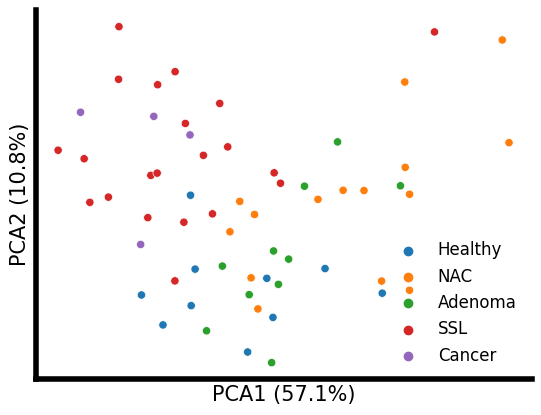

In [15]:
ax = sns.scatterplot(data=X_PCA, x="PCA1", y="PCA2", hue="Ordered type")
plting.transform_plot_ax(ax, legend_title="", remove_ticks=True)
ax.set_xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.figure.savefig(fig_dir / "PCA_gex_tssgenes.svg", bbox_inches='tight')

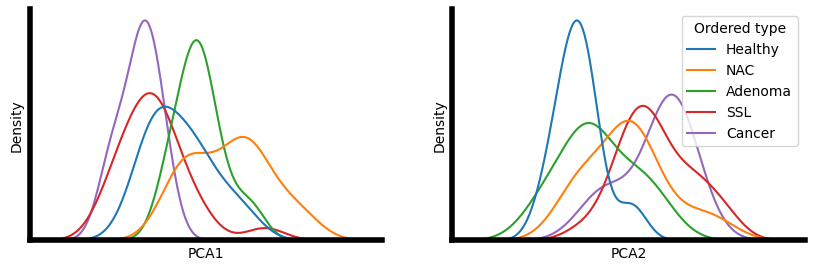

In [16]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
sns.kdeplot(data=X_PCA,x="PCA1",hue="Ordered type", ax=ax[0], legend=False, common_norm=False)
sns.kdeplot(data=X_PCA,x="PCA2",hue="Ordered type", ax=ax[1], common_norm=False)
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].spines[["bottom", "left"]].set_linewidth(4)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].spines[["bottom", "left"]].set_linewidth(4)
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.savefig(fig_dir / "gex_density_pca_advmp_genes.svg", bbox_inches="tight")

In [17]:
ks_2samp(X_PCA[X_PCA["Ordered type"]=="Healthy"]["PCA1"],X_PCA[X_PCA["Ordered type"]!="Healthy"]["PCA1"]),ks_2samp(X_PCA[X_PCA["Ordered type"]=="Healthy"]["PCA2"],X_PCA[X_PCA["Ordered type"]!="Healthy"]["PCA2"])

(KstestResult(statistic=0.18, pvalue=0.9279035888188675),
 KstestResult(statistic=0.72, pvalue=0.00010956692813324749))

In [18]:
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(right_data.drop(["type","Ordered type"],axis=1))
X_PCA = pd.DataFrame(X_PCA, index=right_data.index, columns=["PCA1","PCA2"])
X_PCA = pd.concat([X_PCA, right_data["Ordered type"]],axis=1)
print(pca.explained_variance_ratio_)

[0.52711773 0.18198114]


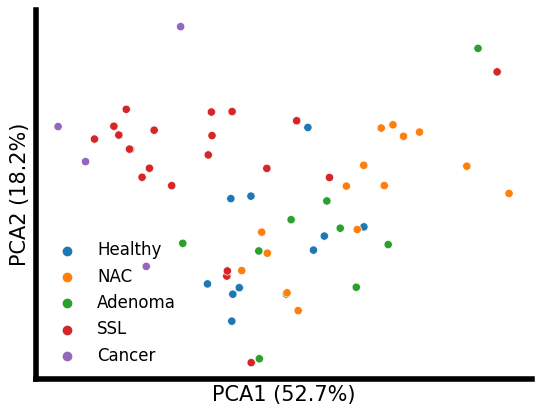

In [19]:
ax = sns.scatterplot(data=X_PCA, x="PCA1", y="PCA2", hue="Ordered type")
plting.transform_plot_ax(ax, legend_title="", remove_ticks=True)
ax.set_xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.figure.savefig(fig_dir / "PCA_gex.svg", bbox_inches='tight')

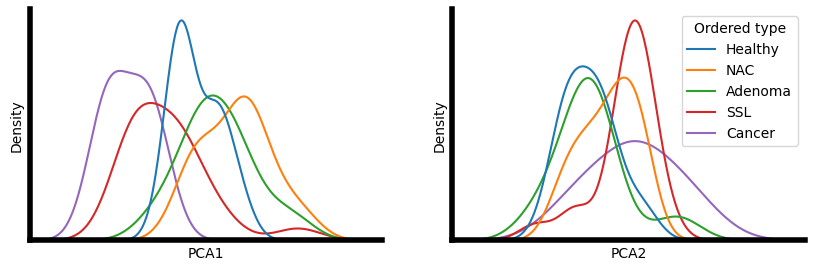

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
sns.kdeplot(data=X_PCA,x="PCA1",hue="Ordered type", ax=ax[0], legend=False, common_norm=False)
sns.kdeplot(data=X_PCA,x="PCA2",hue="Ordered type", ax=ax[1], common_norm=False)
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].spines[["bottom", "left"]].set_linewidth(4)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].spines[["bottom", "left"]].set_linewidth(4)
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.savefig(fig_dir / "gex_density_pca.svg", bbox_inches="tight")

In [21]:
ks_2samp(X_PCA[X_PCA["Ordered type"]=="Healthy"]["PCA1"],X_PCA[X_PCA["Ordered type"]!="Healthy"]["PCA1"]),ks_2samp(X_PCA[X_PCA["Ordered type"]=="Healthy"]["PCA2"],X_PCA[X_PCA["Ordered type"]!="Healthy"]["PCA2"])

(KstestResult(statistic=0.3, pvalue=0.39459210638345227),
 KstestResult(statistic=0.52, pvalue=0.015364482537903207))

# Get differential expression

In [36]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
def get_p_values_cond(data: pd.DataFrame, test_genes: np.array, 
                      pheno1: pd.Series, pheno2: pd.Series) -> np.ndarray:
    p_values = []
    for g in data.columns.intersection(test_genes):
        df = data[g]
        p = mannwhitneyu(df[pheno1].values.ravel(),
                         df[pheno2].values.ravel())[1]
        p_values.append(p)
    return np.array(p_values)

In [37]:
goi = test_genes

def get_gex(goi: np.ndarray) -> pd.DataFrame:
    pheno1 = (right_data["type"]=="Healthy")
    pheno2 = (right_data["type"]=="NAC")
    NAC_p = get_p_values_cond(data=right_data, 
                               test_genes=goi, 
                               pheno1=pheno1, pheno2=pheno2)
    pheno2 = (right_data["type"]=="Adenoma")
    ad_p = get_p_values_cond(data=right_data, 
                               test_genes=goi, 
                               pheno1=pheno1, pheno2=pheno2)
    pheno2 = (right_data["type"]=="SSL")
    ssl_p = get_p_values_cond(data=right_data, 
                               test_genes=goi, 
                               pheno1=pheno1, pheno2=pheno2)
    pheno2 = (right_data["type"]=="Cancer")
    cancer_p = get_p_values_cond(data=right_data, 
                               test_genes=goi, 
                               pheno1=pheno1, pheno2=pheno2)

    diff_expr = pd.DataFrame(np.array([NAC_p,ad_p,ssl_p,cancer_p]),
                             index=["NAC_p","Ad_p","SSL_p","Cancer_p"],columns=goi).T
    for i,col in enumerate(diff_expr.columns):
        q_value = multipletests(diff_expr[col],method="fdr_bh")[1]
        diff_expr[col[:-1]+"q"] = q_value
    return diff_expr

In [38]:
diff_expr = get_gex(goi=goi)

In [39]:
sign_diff = diff_expr["NAC_q"].apply(lambda x: -np.log10(x)).sort_values(ascending=False).to_frame()

In [53]:
from typing import List

def heatmap_significance(sign_diff: pd.DataFrame, annot: pd.DataFrame,
                         fig: plt.Figure, ax: List) -> plt.Figure: 
    part1 = sign_diff.iloc[:int(sign_diff.shape[0]/2),:]
    annot1 = annot.loc[part1.index]
    part2 = sign_diff.iloc[int(sign_diff.shape[0]/2):,:]
    annot2 = annot.loc[part2.index]
    sns.heatmap(data=part1,
                cmap="vlag", center=0, annot=annot1, fmt='',
                vmin=-1, vmax=3, linewidths=1, cbar=False,
                ax=ax[0])
    ax[0].set_ylabel("")
    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    sns.heatmap(data=part2,
                cmap="vlag", center=0, vmin=-1, vmax=3, 
                annot=annot2, fmt='',
                linewidths=1, cbar_kws={"label": "-log10(q)"},
                ax=ax[1])
    ax[1].set_ylabel("")
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    fig.tight_layout()
    return fig

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.1:
        return "*"
    return "ns"

In [54]:
annots = diff_expr.loc[sign_diff.index,["NAC_q"]].applymap(convert_pvalue_to_asterisks)

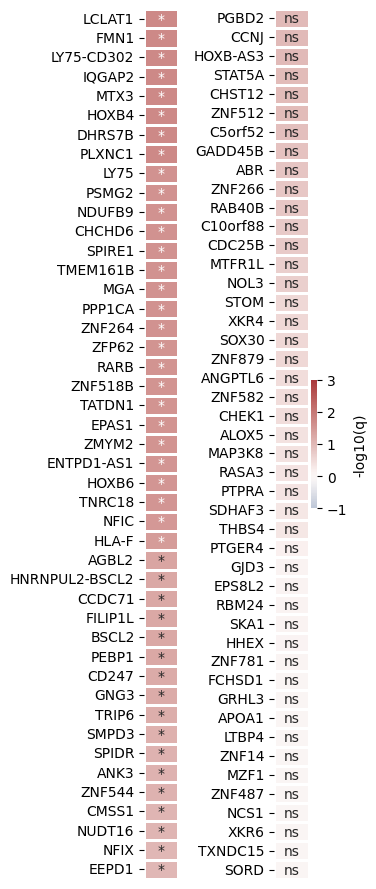

In [55]:
fig, ax = plt.subplots(1,2,figsize=(4,9), width_ratios=[4,5])
fig = heatmap_significance(sign_diff=sign_diff, fig=fig, ax=ax, annot=annots)
fig.savefig(fig_dir / "diff_gex_NAC_heatmap.svg", bbox_inches="tight")

In [56]:
neoplastic_sign_diff = diff_expr[["SSL_q","Cancer_q"]].applymap(lambda x: -np.log10(x))
neoplastic_sign_diff = neoplastic_sign_diff.loc[sign_diff.index]

In [57]:
annots = diff_expr.loc[sign_diff.index,["SSL_q","Cancer_q"]].applymap(convert_pvalue_to_asterisks)

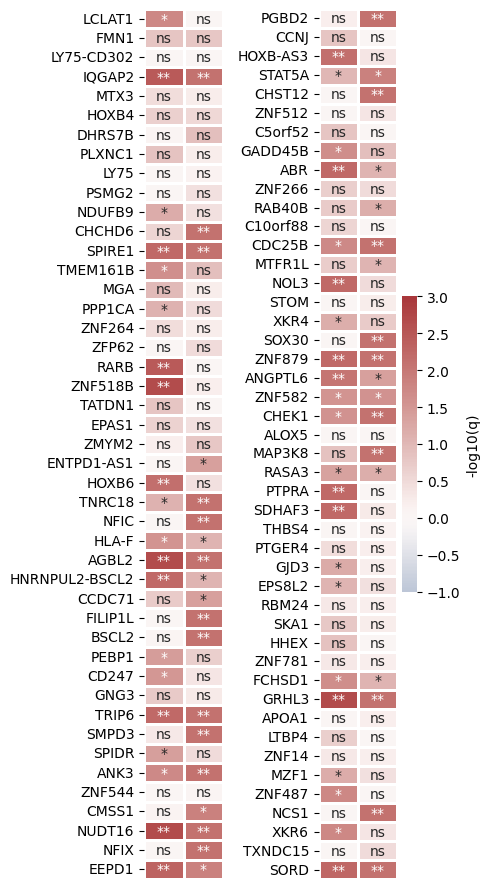

In [58]:
fig, ax = plt.subplots(1,2,figsize=(5,9), width_ratios=[4,5])
fig = heatmap_significance(sign_diff=neoplastic_sign_diff, annot=annots,
                           fig=fig, ax=ax)
fig.savefig(fig_dir / "diff_gex_sslcancer_heatmap.svg", bbox_inches="tight")

In [59]:
def get_gex_boxplot(right_data: pd.DataFrame, gene: str) -> plt.Figure:
    fig, ax = plt.subplots(1,1,figsize=(3,2))
    sns.boxplot(data=right_data, 
                x="type", y=gene, ax=ax,
                order=["Healthy","NAC","Adenoma","SSL","Cancer"], 
                     palette=palette)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
    ax.set_xlabel("")
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines[["bottom", "left"]].set_linewidth(3)
    return fig

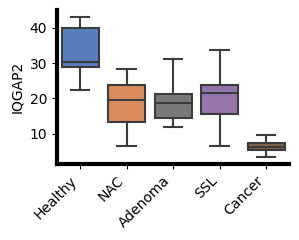

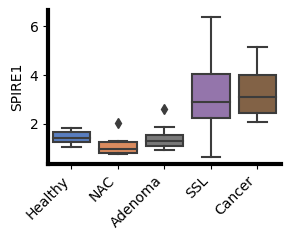

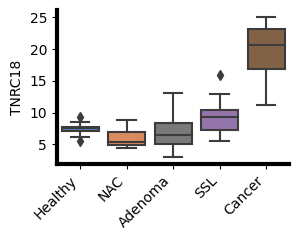

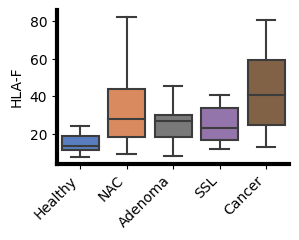

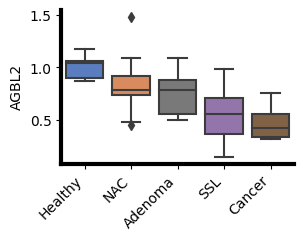

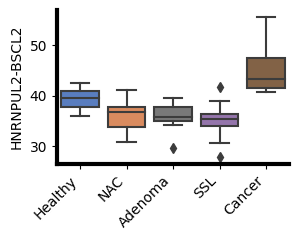

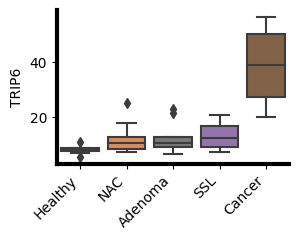

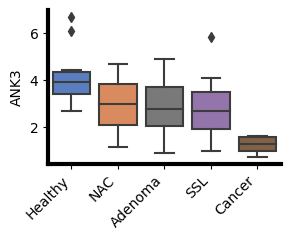

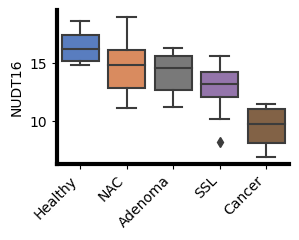

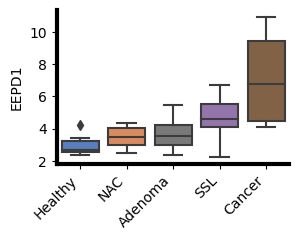

In [60]:
genes_to_plot = ["IQGAP2","SPIRE1","TNRC18","HLA-F","AGBL2",
                 "HNRNPUL2-BSCL2","TRIP6","ANK3","NUDT16","EEPD1"]
for gene in genes_to_plot:
    figure = get_gex_boxplot(right_data=right_data, gene=gene)
    figure.savefig(fig_dir / "diffgexboxplots" / f"{gene}.svg", bbox_inches="tight")

In [61]:
(diff_expr.loc[:,diff_expr.columns.str.endswith("q")]<0.1).sum(axis=1).value_counts()

1    34
2    30
0    17
3    10
dtype: int64

In [62]:
diff_expr

,NAC_p,Ad_p,SSL_p,Cancer_p,NAC_q,Ad_q,SSL_q,Cancer_q
Ensembl_ID,,,,,,,,
PTPRA,0.331685,0.733730,0.000670,0.945055,0.425117,0.824314,0.006010,0.988506
CDC25B,0.113902,0.140465,0.004952,0.001998,0.178708,0.384427,0.018776,0.007905
PTGER4,0.560274,0.021134,0.245200,0.539461,0.688985,0.272507,0.348644,0.645933
IQGAP2,0.000280,0.001706,0.000218,0.001998,0.019611,0.155269,0.003302,0.007905
MTX3,0.001724,0.677585,0.245200,0.453546,0.019611,0.800782,0.348644,0.598155
...,...,...,...,...,...,...,...,...
ZNF781,0.760301,0.104110,0.386335,0.539461,0.864843,0.378960,0.517007,0.645933
ZNF582,0.255482,0.520523,0.009354,0.007992,0.346998,0.667149,0.028373,0.026936
GRHL3,0.846062,0.075662,0.000065,0.001998,0.927610,0.312964,0.002110,0.007905


In [217]:
def get_full_dgex(right_data: pd.DataFrame, test_genes: np.ndarray) -> pd.DataFrame:
    pvalues = []
    for gene in tqdm(right_data.columns[:-2]):
        p = mannwhitneyu(right_data.loc[right_data["type"]=="Healthy",gene],
                 right_data.loc[right_data["type"]=="NAC",gene])[1]
        pvalues.append(p)

    full_dgex = pd.DataFrame(pvalues,index=right_data.columns[:-2], columns=["p"])
    indicator_col = [1 if gene in test_genes else 0 for gene in full_dgex.index]
    full_dgex["Indicator"] = indicator_col
    full_dgex = full_dgex.sort_values(by="p")
    full_dgex["Order"] = np.arange(1,full_dgex.shape[0]+1)[::-1]
    return full_dgex

In [136]:
def compute_ks_random_stat_l(full_dgex: pd.DataFrame, l: int, 
                           posconst: float, 
                           negconst: float) -> float:
    df = full_dgex.iloc[:l]
    dfpos = df[df.Indicator==1]
    if dfpos.shape[0]==0:
        posnum = 0
    else:
        posnum = dfpos.Order.sum()
    dfneg = df[df.Indicator==0]
    if dfneg.shape[0]==0:
        negnum = 0
    else:
        negnum = dfneg.shape[0]
    kstat = posnum/posconst - negnum/negconst
    return kstat

def get_kstat_list(full_dgex: pd.DataFrame) -> List:
    posconst = full_dgex[full_dgex["Indicator"]==1]["Order"].sum()
    negconst = full_dgex.shape[0] - full_dgex.Indicator.sum()
    kstat_list = []
    for l in tqdm(range(1,full_dgex.shape[0]+1)):
        kstat_list.append(compute_ks_random_stat_l(full_dgex=full_dgex, l=l, 
                                                   posconst=posconst, negconst=negconst))
    return kstat_list

In [221]:
red_right_data = right_data[right_data["type"].isin(["Healthy","NAC"])]

In [222]:
full_dgex = get_full_dgex(right_data=red_right_data, test_genes=test_genes)

  0%|          | 0/18969 [00:00<?, ?it/s]

In [223]:
kstat_list = get_kstat_list(full_dgex=full_dgex)

ksplot_df = pd.DataFrame(np.array([np.arange(1,len(kstat_list)+1),kstat_list])).T
ksplot_df.columns = ["x","KS"]

  0%|          | 0/18969 [00:00<?, ?it/s]

/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


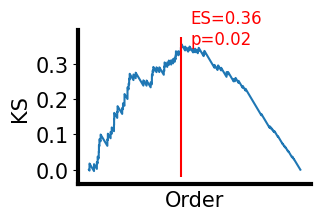

In [238]:
empirical_p = 0.02
fig, ax = plt.subplots(1,1,figsize=(3,2))
sns.lineplot(data=ksplot_df,x="x",y="KS",ax=ax)
plting.transform_plot_ax(ax, legend_title="", linew=3)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("Order")
ES = np.max(np.abs(kstat_list))
ymin, ymax = ax.get_ylim()
ax.vlines(x= np.argmax(np.abs(kstat_list)),ymin=ymin, ymax=ymax, color="r")
ax.text(np.argmax(np.abs(kstat_list))*1.1, ES, f"ES={ES:.2f}\np={empirical_p}", color="r", fontsize=12)
fig.savefig(fig_dir / "ES_tss_genes_dgex.svg", bbox_inches="tight")

In [156]:
all_ES = []
n_permut = 50
for i in tqdm(range(n_permut)):
    random_right = red_right_data.copy()
    random_right["type"] = np.random.permutation(random_right["type"])

    full_dgex = get_full_dgex(right_data=random_right, test_genes=test_genes)
    kstat_list = get_kstat_list(full_dgex=full_dgex)
    all_ES.append(np.max(np.abs(kstat_list)))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

  0%|          | 0/18969 [00:00<?, ?it/s]

In [184]:
empirical_p = len(np.where(np.array(all_ES)>ES)[0])/n_permut

In [185]:
empirical_p

0.02

In [182]:
np.array(all_ES)

array([0.29238029, 0.29959195, 0.29239114, 0.30821191, 0.29096466,
       0.34632681, 0.29164987, 0.30619752, 0.20156224, 0.27972331,
       0.28203359, 0.32181197, 0.27015635, 0.24823057, 0.20146035,
       0.24059537, 0.32250105, 0.22003804, 0.34403143, 0.25030698,
       0.32306922, 0.30965372, 0.30932045, 0.27539322, 0.2656795 ,
       0.20800241, 0.28994616, 0.28350439, 0.32823518, 0.27475835,
       0.26478135, 0.30324661, 0.22294289, 0.36164976, 0.26104964,
       0.26850052, 0.33284549, 0.24377131, 0.31852526, 0.31801283,
       0.34314924, 0.2427508 , 0.23825158, 0.26197027, 0.24859402,
       0.26423693, 0.28739556, 0.20715181, 0.26519369, 0.2723444 ])

# Get differential expression poised

In [201]:
goi = poised_genes

In [202]:
diff_expr = get_gex(goi=goi)

In [203]:
sign_diff = diff_expr["NAC_q"].apply(lambda x: -np.log10(x)).sort_values(ascending=False).to_frame()

In [204]:
annots = diff_expr.loc[sign_diff.index,["NAC_q"]].applymap(convert_pvalue_to_asterisks)

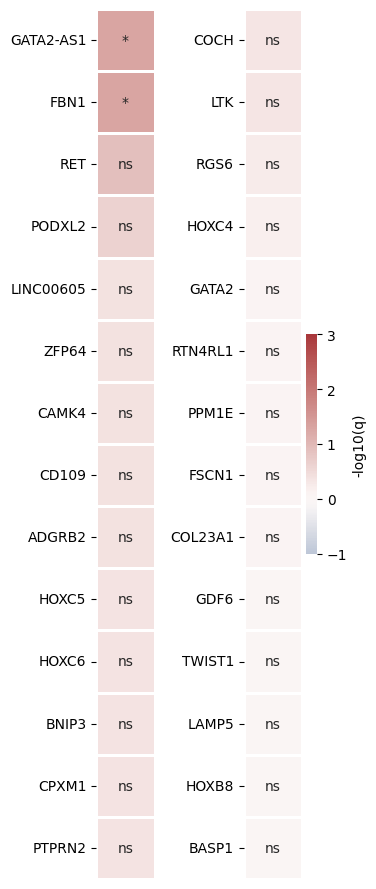

In [205]:
fig, ax = plt.subplots(1,2,figsize=(4,9), width_ratios=[4,5])
fig = heatmap_significance(sign_diff=sign_diff, fig=fig, ax=ax, annot=annots)
fig.savefig(fig_dir / "diff_gex_poised_NAC_heatmap.svg", bbox_inches="tight")

In [207]:
neoplastic_sign_diff = diff_expr[["SSL_q","Cancer_q"]].applymap(lambda x: -np.log10(x))
neoplastic_sign_diff = neoplastic_sign_diff.loc[sign_diff.index]

In [208]:
annots = diff_expr.loc[sign_diff.index,["SSL_q","Cancer_q"]].applymap(convert_pvalue_to_asterisks)

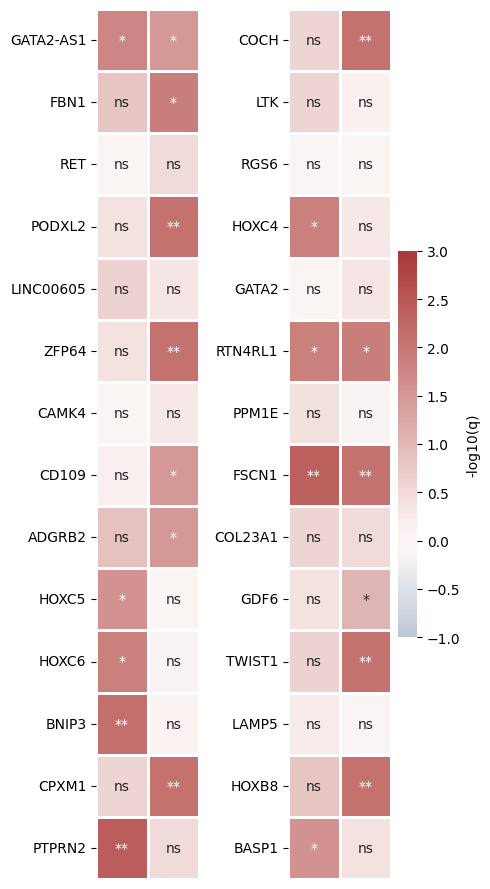

In [209]:
fig, ax = plt.subplots(1,2,figsize=(5,9), width_ratios=[4,5])
fig = heatmap_significance(sign_diff=neoplastic_sign_diff, annot=annots,
                           fig=fig, ax=ax)
fig.savefig(fig_dir / "diff_gex_poised_sslcancer_heatmap.svg", bbox_inches="tight")

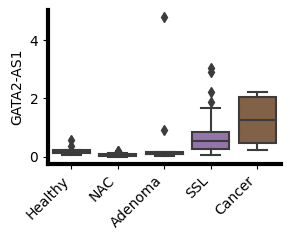

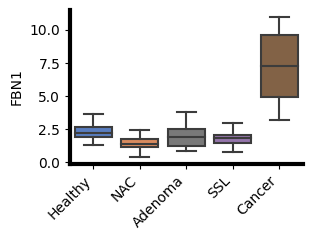

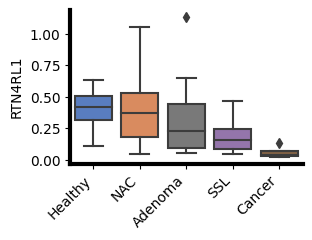

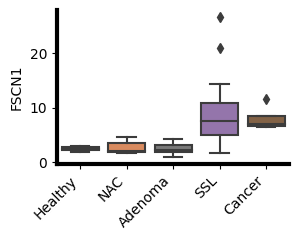

In [212]:
genes_to_plot = ["GATA2-AS1","FBN1","RTN4RL1","FSCN1"]
for gene in genes_to_plot:
    figure = get_gex_boxplot(right_data=right_data, gene=gene)
    figure.savefig(fig_dir / "diffgexboxplots" / f"{gene}_poised.svg", bbox_inches="tight")

In [213]:
(diff_expr.loc[:,diff_expr.columns.str.endswith("q")]<0.1).sum(axis=1).value_counts()

1    15
0     9
2     3
3     1
dtype: int64

In [214]:
diff_expr

,NAC_p,Ad_p,SSL_p,Cancer_p,NAC_q,Ad_q,SSL_q,Cancer_q
Ensembl_ID,,,,,,,,
CPXM1,0.192389,1.000000,0.169636,0.001998,0.424007,1.000000,0.263878,0.007992
LAMP5,1.000000,0.427355,0.459597,0.945055,1.000000,0.629787,0.559510,0.945055
ZFP64,0.101763,0.909722,0.300522,0.001998,0.395587,1.000000,0.397220,0.007992
BASP1,0.933689,0.969850,0.008264,0.239760,1.000000,1.000000,0.027265,0.394899
CAMK4,0.113902,0.384673,0.849184,0.373626,0.395587,0.629787,0.880635,0.498168
COL23A1,0.560274,0.064022,0.144871,0.187812,0.824651,0.377759,0.258395,0.328671
CD109,0.127153,0.677585,0.568353,0.013986,0.395587,0.824886,0.663078,0.032634
FSCN1,0.637287,0.520523,0.000303,0.001998,0.824651,0.728732,0.004237,0.007992
PTPRN2,0.212003,0.025748,0.000131,0.187812,0.424007,0.360473,0.003672,0.328671


In [215]:
red_right_data = right_data[right_data["type"].isin(["Healthy","NAC"])]

In [218]:
full_dgex = get_full_dgex(right_data=red_right_data, test_genes=poised_genes)

  0%|          | 0/18969 [00:00<?, ?it/s]

In [219]:
kstat_list = get_kstat_list(full_dgex=full_dgex)

ksplot_df = pd.DataFrame(np.array([np.arange(1,len(kstat_list)+1),kstat_list])).T
ksplot_df.columns = ["x","KS"]

  0%|          | 0/18969 [00:00<?, ?it/s]

/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


Text(12472, 0.19364603923602342, 'ES=0.19')

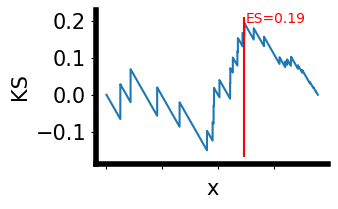

In [220]:
fig, ax = plt.subplots(1,1,figsize=(3,2))
sns.lineplot(data=ksplot_df,x="x",y="KS",ax=ax)
plting.transform_plot_ax(ax, legend_title="")
ax.set_xticklabels([])
ES = np.max(np.abs(kstat_list))
ymin, ymax = ax.get_ylim()
ax.vlines(x= np.argmax(np.abs(kstat_list)),ymin=ymin, ymax=ymax, color="r")
ax.text(np.argmax(np.abs(kstat_list))+100, ES, f"ES={ES:.2f}", color="r")